<a href="https://colab.research.google.com/github/TeyrCrimson/tensorflow-projects/blob/master/Plant_seedlings_classification_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_dir = '/content/drive/My Drive/Machine Learning/plant-seedlings-classification/train'
validation_dir = '/content/drive/My Drive/Machine Learning/plant-seedlings-classification/test/test'
image_size = 224

In [0]:
import pandas as pd
import os
sample_submission = pd.read_csv('/content/drive/My Drive/Machine Learning/plant-seedlings-classification/sample_submission/sample_submission.csv')

In [0]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [5]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense, LeakyReLU
from keras.applications import ResNet50, VGG19
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D
from keras import backend as K
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint
from PIL import Image
import matplotlib.pyplot as plt
import keras
import cv2
import glob
import datetime

Using TensorFlow backend.


# Defined Functions

In [0]:
def hsvmask(img):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)
    lower = np.array([45,0,0])
    upper = np.array([95,255,255])
    mask = cv2.inRange(hsv,lower,upper)
    #struc = cv2.getStructuringElement(cv2.MORPH_RECT,(11,11))
    #mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    #boolean = mask>0
    #boolean = np.dstack([boolean]*3)
    new = np.zeros_like(img,np.uint8)
    new = cv2.bitwise_and(img,img,mask=mask)
    return new

In [0]:
def hsv(img):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)
    return hsv

In [0]:
def remove_white(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
  img[thresh == 255] = 0
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
  erosion = cv2.erode(img, kernel, iterations=1)
  return erosion

# Data Preparation + Preprocessing

In [9]:
train = []
y_train1=[]
test = []
train1=[]
validation=[]

for category_id, category in enumerate(CATEGORIES):
    for file in glob.glob(os.path.join('{}/{}/*.png'.format(train_dir,category))):
        train.append([file, category_id, category])
        image = cv2.imread (file)
        image = cv2.resize(remove_white(hsvmask(image)),(image_size,image_size))
        train1.append (image)
        y_train1.append(category_id)
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

for file in glob.glob(os.path.join('{}/*.png'.format(validation_dir))):
        test.append([file])
        image = cv2.imread (file)
        image = cv2.resize(remove_white(hsvmask(image)),(image_size,image_size))
        #image = load_img(file, target_size=(200, 200))
        #image = img_to_array(image)
        validation.append (image)
test = pd.DataFrame(test, columns=['file'])

len(train1)

4750

Image Data Generator for Data Augmentation

In [0]:
train_datagen = ImageDataGenerator(rotation_range=360,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)

# Images

Original Images

/content/drive/My Drive/Machine Learning/plant-seedlings-classification/train/0050f38b3.png


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


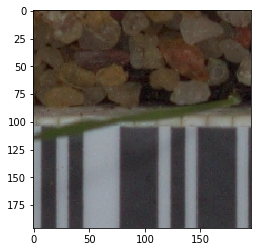

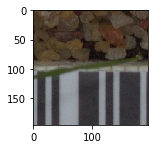

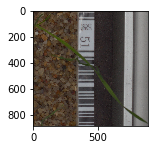

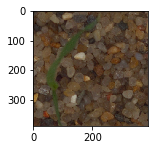

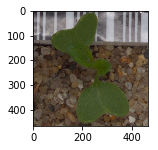

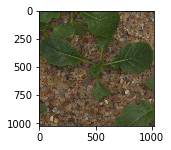

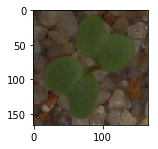

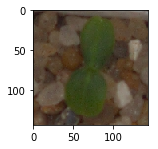

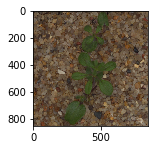

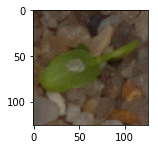

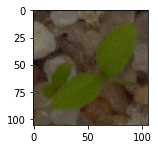

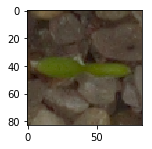

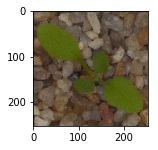

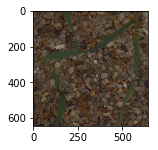

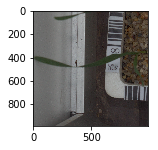

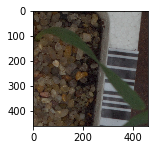

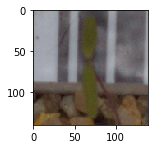

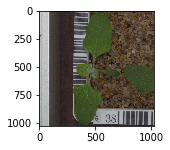

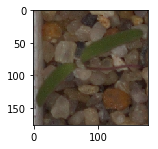

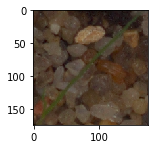

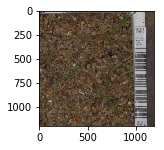

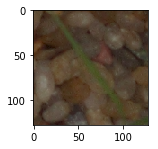

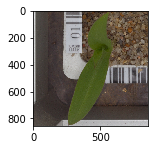

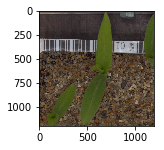

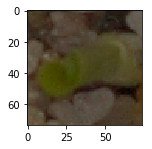

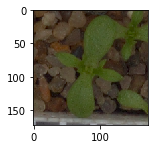

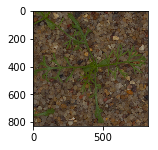

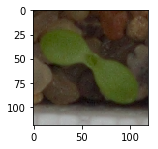

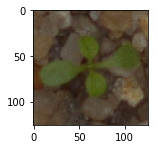

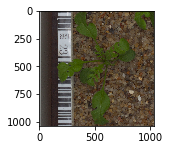

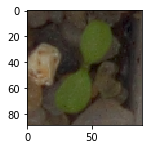

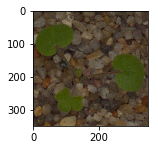

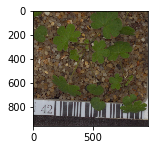

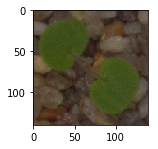

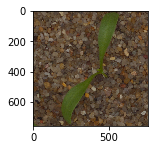

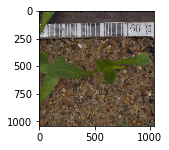

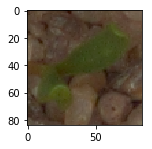

In [11]:
files = []
files.append(os.listdir(f'{train_dir}/Black-grass')[:3])
files.append(os.listdir(f'{train_dir}/Charlock')[:3])
files.append(os.listdir(f'{train_dir}/Cleavers')[:3])
files.append(os.listdir(f'{train_dir}/Common Chickweed')[:3])
files.append(os.listdir(f'{train_dir}/Common wheat')[:3])
files.append(os.listdir(f'{train_dir}/Fat Hen')[:3])
files.append(os.listdir(f'{train_dir}/Loose Silky-bent')[:3])
files.append(os.listdir(f'{train_dir}/Maize')[:3])
files.append(os.listdir(f'{train_dir}/Scentless Mayweed')[:3])
files.append(os.listdir(f'{train_dir}/Shepherds Purse')[:3])
files.append(os.listdir(f'{train_dir}/Small-flowered Cranesbill')[:3])
files.append(os.listdir(f'{train_dir}/Sugar beet')[:3])

print(train_dir + '/' + files[0][0])
img = plt.imread(os.path.join(train_dir,CATEGORIES[0], files[0][0]))
plt.imshow(img)
count = 1
for i in range(len(files)):
  for j in range(3):
    f = plt.figure(figsize=(30,30))
    img = plt.imread(os.path.join(train_dir,CATEGORIES[i], files[i][j]))
    f.add_subplot(12,3,count)
    count = count + 1
    plt.imshow(img, aspect=1)

Images converted to HSV

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

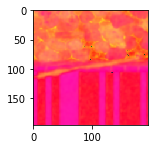

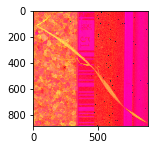

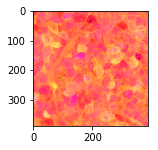

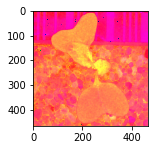

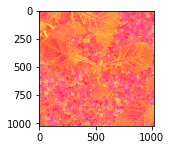

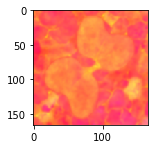

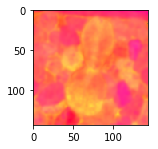

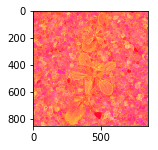

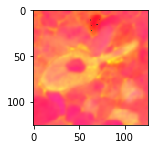

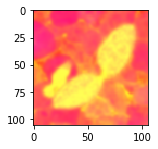

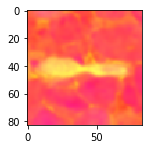

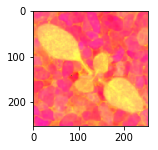

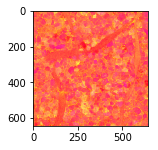

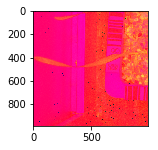

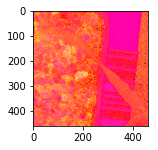

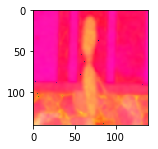

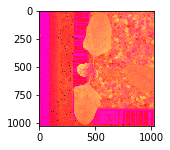

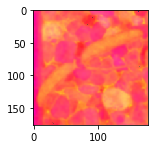

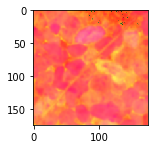

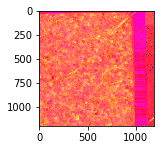

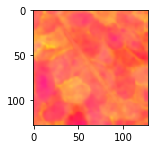

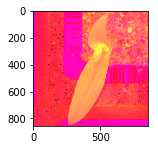

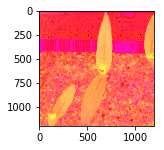

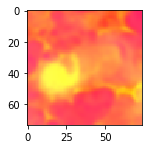

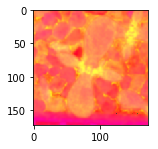

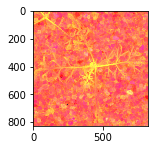

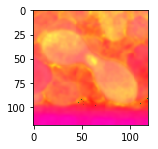

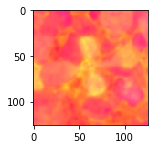

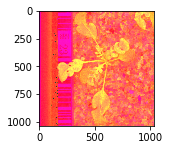

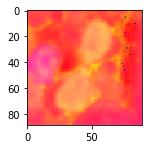

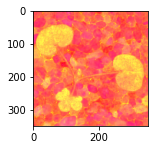

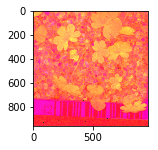

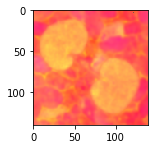

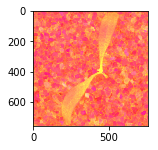

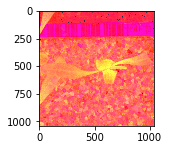

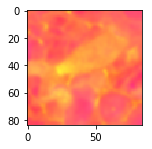

In [12]:
count = 1
for i in range(len(files)):
  for j in range(3):
    f = plt.figure(figsize=(30,30))
    img = plt.imread(os.path.join(train_dir,CATEGORIES[i], files[i][j]))
    f.add_subplot(12,3,count)
    count = count + 1
    plt.imshow(hsv(img), aspect=1)

Images after HSV mask + noise removal

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


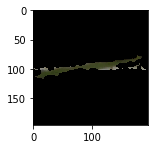

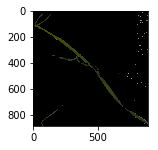

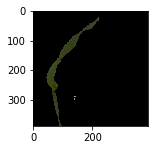

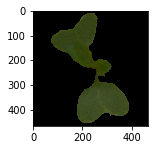

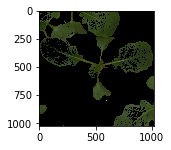

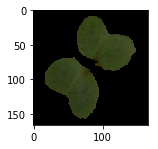

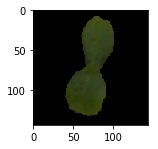

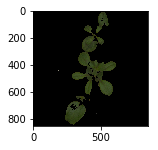

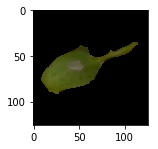

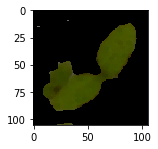

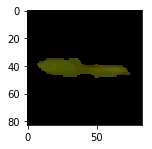

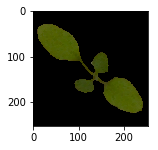

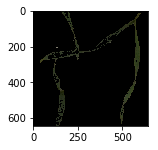

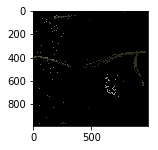

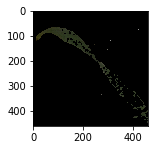

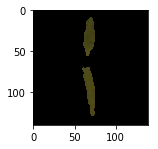

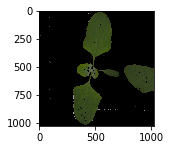

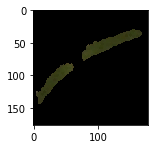

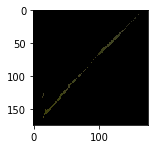

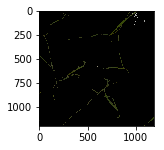

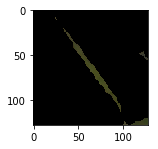

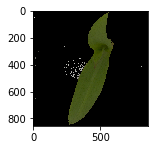

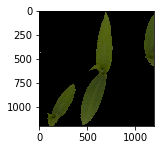

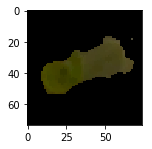

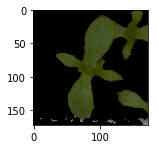

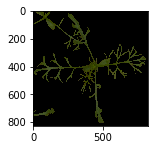

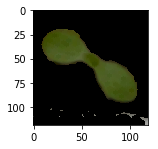

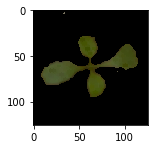

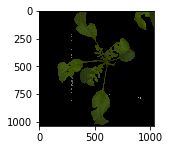

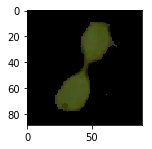

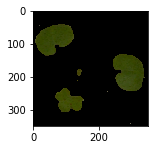

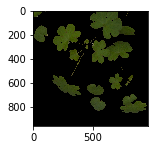

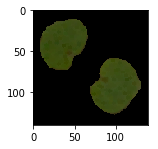

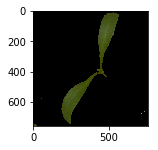

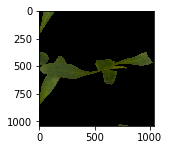

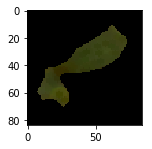

In [13]:
count = 1
for i in range(len(files)):
  for j in range(3):
    f = plt.figure(figsize=(30,30))
    img = plt.imread(os.path.join(train_dir,CATEGORIES[i], files[i][j]))
    f.add_subplot(12,3,count)
    count = count + 1
    plt.imshow(remove_white(hsvmask(img)), aspect=1)

# Model Setup

Setting class weights. Achieved by creating ratios based on the maximum number of files out of all 12 classes.

In [14]:
class_size = [len(files) for r, d, files in os.walk(train_dir)][1:]
class_size = [max(class_size) / x for x in class_size]
class_weights = {}
for i in range(len(class_size)):
  class_weights.update({i: class_size[i]})
#[len(files) for r, d, files in os.walk(train_dir)][1:]
class_weights[0] = class_weights[0]*1.5
#class_weights[2] = class_weights[2]*3
#class_weights[4] = class_weights[4]*3
class_weights[6] = class_weights[6]*1.5
#class_weights[8] = class_weights[8]*1.5
class_weights

{0: 3.7300380228136882,
 1: 1.676923076923077,
 2: 2.278745644599303,
 3: 1.0703764320785598,
 4: 2.9592760180995477,
 5: 1.3768421052631579,
 6: 1.5,
 7: 2.9592760180995477,
 8: 1.2674418604651163,
 9: 2.831168831168831,
 10: 1.3185483870967742,
 11: 1.6987012987012986}

Setting training checkpoints

In [0]:
str(datetime.date.today())

filepath = "/content/drive/My Drive/Machine Learning/" + str(datetime.date.today()) + "-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(np.array(train1),np.array(y_train1), test_size=0.2, shuffle=True, random_state=42)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255
def get_model():
    model = Sequential()  
  
    #1st conv
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same',input_shape=X_train[0].shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
  
    #2nd conv
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    #3rd conv
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
  
    #GAP layer
    model.add(GlobalAveragePooling2D())
  
    #dense layer
    model.add(Dense(units=128, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(units=128, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))      
    model.add(Dense(units=12, activation='softmax'))
  
    return model
  
#Parameters  
learning_rate = 0.001
momentum = 0.9
sgd = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=True)
#adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model_sgd = get_model()
model_sgd.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 55, 55, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)    

In [36]:
model_sgd.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['acc'])
history_sgd = model_sgd.fit_generator(train_datagen.flow(X_train, y_train, batch_size=16),
                                     validation_data=(X_test,y_test),
                                     steps_per_epoch=X_train.shape[0]//16,
                                     epochs=10,
                                     callbacks=callbacks_list,
                                     class_weight = class_weights,
                                     verbose=1,
                                     shuffle=True)

Epoch 1/10
237/237 [==============================] - 35s 147ms/step - loss: 0.4145 - acc: 0.9130 - val_loss: 0.2659 - val_acc: 0.9116

Epoch 00001: val_acc did not improve from 0.91158
Epoch 2/10
237/237 [==============================] - 35s 149ms/step - loss: 0.4402 - acc: 0.9159 - val_loss: 0.2793 - val_acc: 0.8947

Epoch 00002: val_acc did not improve from 0.91158
Epoch 3/10
237/237 [==============================] - 36s 150ms/step - loss: 0.4329 - acc: 0.9106 - val_loss: 0.2673 - val_acc: 0.9095

Epoch 00003: val_acc did not improve from 0.91158
Epoch 4/10
237/237 [==============================] - 35s 149ms/step - loss: 0.4369 - acc: 0.9095 - val_loss: 0.2632 - val_acc: 0.9095

Epoch 00004: val_acc did not improve from 0.91158
Epoch 5/10
237/237 [==============================] - 34s 144ms/step - loss: 0.4243 - acc: 0.9153 - val_loss: 0.2746 - val_acc: 0.9042

Epoch 00005: val_acc did not improve from 0.91158
Epoch 6/10
237/237 [==============================] - 35s 147ms/step -

# Post-training Functions

In [0]:
model_sgd.load_weights('/content/drive/My Drive/Machine Learning/absolutebest.hdf5')

Confusion Matrix for error checking.

In [37]:
from sklearn.metrics import confusion_matrix
# PREDICTIONS
y_pred = model_sgd.predict(X_test)
#print(y_pred)
y_class = np.argmax(y_pred, axis=1)
#print(y_class)
#print(y_test)
y_check = y_test
#print(y_check)
cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[ 58   0   0   0   2   0   7   0   0   0   0   0]
 [  0  79   0   0   0   0   0   0   0   0   0   0]
 [  0   1  54   1   0   0   0   0   0   0   1   0]
 [  1   0   2 114   0   0   2   1   0   1   0   4]
 [  1   0   0   0  34   0   0   0   0   0   0   0]
 [  0   0   1   1   4  73   0   0   0   0   0   1]
 [ 36   0   0   0   2   0 101   0   1   0   0   0]
 [  0   0   0   0   0   0   0  45   0   0   0   1]
 [  2   0   0   3   0   0   0   0  87   1   0   1]
 [  0   1   0   3   0   0   0   0   1  37   0   0]
 [  0   1   0   0   0   0   0   1   0   0  99   0]
 [  0   1   0   0   0   0   0   2   0   0   0  81]]


Used to freeze layers for further training

In [25]:
for layer in model_sgd.layers:
  layer.trainable = True
for layer in model_sgd.layers[:-7]:
  layer.trainable = False

for layer in model_sgd.layers:
  print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f2d0f0d7eb8> False
<keras.layers.normalization.BatchNormalization object at 0x7f2d0f0e6358> False
<keras.layers.convolutional.Conv2D object at 0x7f2d0f0e62e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2d0f0e6400> False
<keras.layers.normalization.BatchNormalization object at 0x7f2d005b8f98> False
<keras.layers.convolutional.Conv2D object at 0x7f2d005b8978> False
<keras.layers.normalization.BatchNormalization object at 0x7f2d0045c8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f2d004bde80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2d00368a20> False
<keras.layers.normalization.BatchNormalization object at 0x7f2d003c8b00> False
<keras.layers.convolutional.Conv2D object at 0x7f2d002fbd68> False
<keras.layers.normalization.BatchNormalization object at 0x7f2d002ac8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f2d0026ad68> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2d001b6828> False
<k

Generating CSV file for submission

In [0]:
import csv
from google.colab import files

savePath = '/content/drive/My Drive/Machine Learning/'

with open(str(savePath)+'submission.csv','w') as f1:
  writer = csv.writer(f1, delimiter=',', lineterminator='\n')
  #print(validation[0])
  #print(Y_new[0])
  writer.writerow(['file','species'])
  for i in range(len(validation)):
    xid = test.iloc[i]['file'].replace(validation_dir, '')[1:]
    data = CATEGORIES[model_sgd.predict_classes(np.expand_dims(validation[i]/255, axis=0))[0]]
    writer.writerow([xid, data])
  #files.download(str(savePath)+'submission.csv')